# Assistance Listings Clustering Experiment

Let's try to cluster the assistance listings using TFIDF and KMeans.

See https://www.kaggle.com/code/jbencina/clustering-documents-with-tfidf-and-kmeans/notebook

## Key Imports

In [1]:
import os
import pandas as pd
import numpy as np


from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

## Now import the Assistance Listings

In [2]:
# Read the CSV File into a dataframe

data = pd.read_csv('AssistanceListings_USASpendingGov_PUBLIC_WEEKLY_20220101.csv',encoding='cp1252',
                           usecols=['Program Title','Program Number','Federal Agency (030)','Objectives (050)'])

# Join Program Title, Federal Agency and Objectives into a single text field
data['text'] = data[['Program Title','Federal Agency (030)','Objectives (050)']].agg(' '.join, axis=1)

data

,Program Title,Program Number,Federal Agency (030),Objectives (050),text
0,Agricultural Research Basic and Applied Research,10.001,"AGRICULTURAL RESEARCH SERVICE, AGRICULTURE, DE...","To make agricultural research discoveries, eva...",Agricultural Research Basic and Applied Resear...
1,"Plant and Animal Disease, Pest Control, and An...",10.025,"ANIMAL AND PLANT HEALTH INSPECTION SERVICE, AG...",To protect U.S. agriculture from economically ...,"Plant and Animal Disease, Pest Control, and An..."
2,Wildlife Services,10.028,"ANIMAL AND PLANT HEALTH INSPECTION SERVICE, AG...",To reduce damage caused by mammals and birds a...,Wildlife Services ANIMAL AND PLANT HEALTH INSP...
3,Avian Influenza Indemnity Program,10.029,"ANIMAL AND PLANT HEALTH INSPECTION SERVICE, AG...",The Animal and Plant Health Inspection Service...,Avian Influenza Indemnity Program ANIMAL AND P...
4,Indemnity Program,10.030,"ANIMAL AND PLANT HEALTH INSPECTION SERVICE, AG...",Animal and Plant Health Inspection Service adm...,Indemnity Program ANIMAL AND PLANT HEALTH INSP...
...,...,...,...,...,...
3302,Food for Peace Emergency Program (EP),98.008,"AGENCY FOR INTERNATIONAL DEVELOPMENT, AGENCY F...","To improve access, availability and utilizatio...",Food for Peace Emergency Program (EP) AGENCY F...
3303,John Ogonowski Farmer-to-Farmer Program,98.009,"AGENCY FOR INTERNATIONAL DEVELOPMENT, AGENCY F...",Improve global food production and marketing b...,John Ogonowski Farmer-to-Farmer Program AGENC...
3304,Denton Program,98.010,"AGENCY FOR INTERNATIONAL DEVELOPMENT, AGENCY F...",To put the empty space on U.S. Military transp...,Denton Program AGENCY FOR INTERNATIONAL DEVELO...
3305,Global Development Alliance,98.011,"AGENCY FOR INTERNATIONAL DEVELOPMENT, AGENCY F...",The Global Development Alliance (GDA) business...,Global Development Alliance AGENCY FOR INTERNA...


In [3]:
# Now Extract the Keywords
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(data['text'])
text = tfidf.transform(data['text'])

## Finding Optimal Clusters (from jbencina)
Clustering is an unsupervised operation, and KMeans requires that we specify the number of clusters. One simple approach is to plot the SSE for a range of cluster sizes. We look for the "elbow" where the SSE begins to level off. MiniBatchKMeans introduces some noise so I raised the batch and init sizes higher. Unfortunately the regular Kmeans implementation is too slow. You'll notice different random states will generate different charts. Here I chose 14 clusters.

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


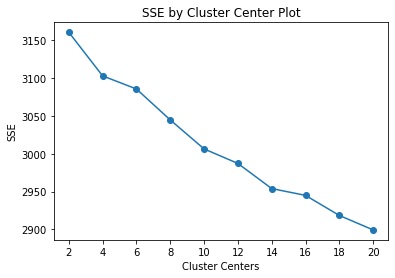

In [4]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 20)

In [5]:
# Now create the 14 clusters
clusters = MiniBatchKMeans(n_clusters=14, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

## Plotting Clusters (from jbencina)
Here we plot the clusters generated by our KMeans operation. One plot uses PCA which is better at capturing global structure of the data. The other uses TSNE which is better at capturing relations between neighbors. In order to speed up the process with TSNE, I sample from 3,000 documents and perform a PCA 50 dimension reduction on the data first. Next I show a scatterplot further sampling the sample down to 300 points.

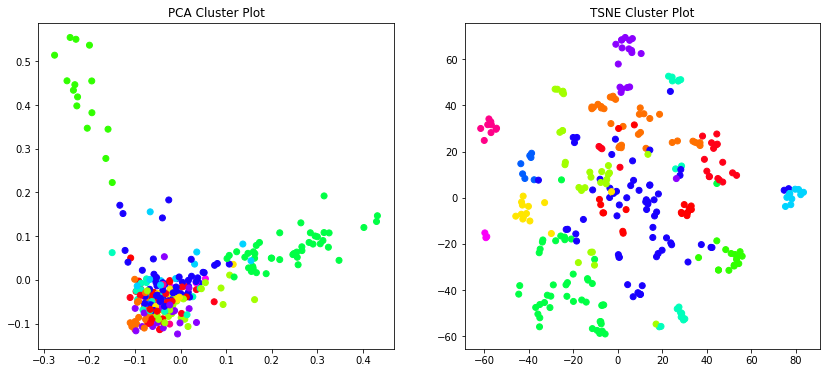

In [6]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

## Top Keywords (from jbencina)
Lastly, we'll cycle through the clusters and print out the top keywords based on their TFIDF score to see if we can spot any trends. I'll do this by computing an average value across all dimensions in Pandas, grouped by the cluster label. Using numpy, finding the top words is simply sorting the average values for each row, and taking the top N.

In [7]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
department,united,programs,educational,interior,international,cultural,affairs,bureau,indian

Cluster 1
program,agricultural,interior,farm,fish,forest,wildlife,agriculture,conservation,service

Cluster 2
program,assistance,state,victims,programs,criminal,law,enforcement,crime,justice

Cluster 3
development,technology,transportation,oceanic,administration,atmospheric,commerce,science,national,research

Cluster 4
mortgage,commissioner,rural,secretary,income,low,community,urban,development,housing

Cluster 5
control,program,centers,public,disease,prevention,human,care,services,health

Cluster 6
program,department,businesses,research,administration,development,rural,small,energy,business

Cluster 7
residence,department,administration,veteran,benefits,care,spending,va,affairs,veterans

Cluster 8
federal,local,disaster,department,program,preparedness,management,emergency,homeland,security

Cluster 9
development,provide,office,employment,grants,department,assistance,program,service